<a href="https://colab.research.google.com/github/magudeswaranpk/Html5-and-Css3/blob/main/DhvaniHackathon_Magudeswaran_PK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Write an algorithm that will detect the defect in the images given below. Breakup of the mark is as given below ** Expecting a general algorithm that works for different diameter, transaltions during image acquisiton etc .

In [1]:
import cv2
import numpy as np

img_path = "/content/sample_data/Image.png"
img = cv2.imread(img_path)

if img is None:
    raise FileNotFoundError(f"Could not load image at {img_path}")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_blur = cv2.medianBlur(gray, 5)

circles = cv2.HoughCircles(
    gray_blur,
    cv2.HOUGH_GRADIENT,
    dp=1.2,
    minDist=30,
    param1=50,
    param2=30,
    minRadius=0,
    maxRadius=0
)

if circles is None:
    raise ValueError("No circles detected. Adjust HoughCircles parameters.")

circles = np.uint16(np.around(circles))
sorted_circles = sorted(circles[0, :], key=lambda x: x[2])
inner_r = sorted_circles[0][2]
outer_r = sorted_circles[-1][2]
center_x, center_y = sorted_circles[-1][0], sorted_circles[-1][1]

_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

mask = np.zeros_like(thresh)
cv2.circle(mask, (center_x, center_y), outer_r, 255, -1)
cv2.circle(mask, (center_x, center_y), inner_r, 0, -1)

diff = cv2.absdiff(mask, thresh)

flashes = cv2.bitwise_and(diff, diff, mask=cv2.subtract(thresh, mask))
cuts = cv2.bitwise_and(diff, diff, mask=cv2.subtract(mask, thresh))


contours_flash, _ = cv2.findContours(flashes, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours_cut, _ = cv2.findContours(cuts, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours_flash:
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
for cnt in contours_cut:
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 2)

cv2.imwrite("output.png", img)
print("Defect detection complete. Saved as output.png")


Defect detection complete. Saved as output.png


# flowchart TD
  A[Start: Load Image] --> B[Preprocessing]
  B --> B1[Convert to Grayscale]
  B1 --> B2[Noise Reduction (Gaussian / Median)]
  B2 --> B3[Contrast Enhancement (CLAHE optional)]
  B3 --> C[Segmentation]
  C --> C1[Adaptive Threshold or Otsu]
  C1 --> C2[Morphological Opening/Closing]
  C2 --> D[Object Detection]
  D --> D1[Find Largest Contour(s) or Hough Circles]
  D1 --> D2[Estimate Center, Outer & Inner Radii]
  D2 --> E[Normalize & Align]
  E --> E1[Crop with Padding / Resize to Canonical Size]
  E1 --> F[Generate Ideal Ring Mask]
  F --> G[Compute Difference: (Observed XOR Ideal)]
  G --> G1[Separate Positive & Negative Residuals]
  G1 --> H1[Positive Residuals -> Candidate Flashes]
  G1 --> H2[Negative Residuals -> Candidate Cuts]
  H1 --> I1[Postprocess: Morphology & Area Filter]
  H2 --> I2[Postprocess: Morphology & Area Filter]
  I1 --> J1[Localize: Contours / Bounding Boxes / Centroids]
  I2 --> J2[Localize: Contours / Bounding Boxes / Centroids]
  J1 --> K[Classify & Report]
  J2 --> K
  K --> L[Output: Annotated Image + CSV of Defects]
  L --> M[End]

# 2.Write a program to plot following equation over time. the equation defines a dynamical system in which position of the system changes with time . you have to plot the positions over time. Think of this as a Bee moving in 3d space. you need to plot the path taken by the Bee.Assume x , y , z are points in 3d space in which x 0 = 0 , y 0 = 1 , z 0 = 1.05 and a = 10 , b = 28 , c = 2.667 are the parameters and x ˙ = d x d t , similar for y and z .The equations are

x ˙ = a ∗ ( y − b )

y ˙ = b ∗ x − y − x ∗ z

z ˙ = x ∗ y − c ∗ z

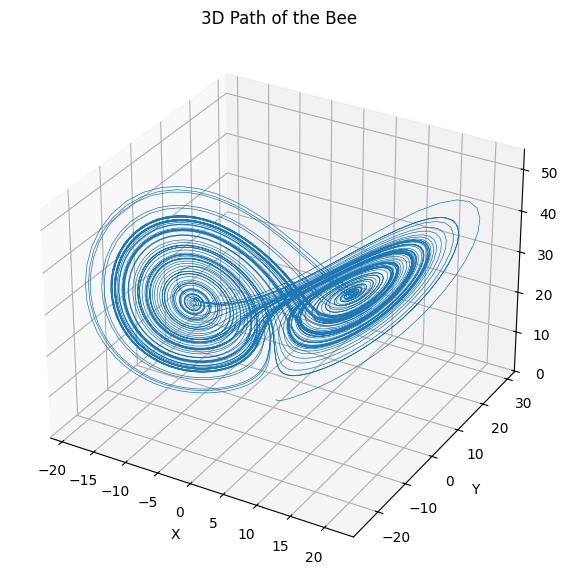

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

a = 10.0
b = 28.0
c = 2.667

x, y, z = 0.0, 1.0, 1.05

dt = 0.01
steps = 10000

xs = np.empty(steps)
ys = np.empty(steps)
zs = np.empty(steps)


for i in range(steps):
    xs[i], ys[i], zs[i] = x, y, z
    dx = a * (y - x)
    dy = b * x - y - x * z
    dz = x * y - c * z
    x += dx * dt
    y += dy * dt
    z += dz * dt

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs, ys, zs, lw=0.5)
ax.set_title("3D Path of the Bee")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

# **3. The objective is to predict the location and type of vehicle found in the scene using the images provided. The images have annotations in xml format, and the task is to create an Object Detector and Classifier.Eg: Cars, Bus, Motorbikes etc. Select 3 or 4 classes from the provided dataset and build the training module. Each Image may or may not have the classes to identify. You can find description along with the dataset.**

In [4]:
import os, xml.etree.ElementTree as ET, shutil, random
from pathlib import Path


VOC_ANN_DIR = "Annotations"
IMG_DIR = "JPEGImages"
OUT_DIR = "dataset"
RANDOM_SEED = 42
VAL_RATIO = 0.2


CLASSES = ["car", "bus", "truck", "motorbike"]
CLASS_MAP = {name: i for i, name in enumerate(CLASSES)}

os.makedirs(OUT_DIR, exist_ok=True)
for sub in ["images/train","images/val","labels/train","labels/val"]:
    os.makedirs(os.path.join(OUT_DIR, sub), exist_ok=True)

xml_files = list(Path(VOC_ANN_DIR).glob("*.xml"))
random.seed(RANDOM_SEED)
random.shuffle(xml_files)
num_val = int(len(xml_files) * VAL_RATIO)

def convert_one(xml_path, is_val=False):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    filename = root.find('filename').text
    img_path = Path(IMG_DIR)/filename
    if not img_path.exists():
        alt = img_path.with_suffix('.jpg')
        if alt.exists(): img_path = alt
        else:
            print("Image not found for", filename); return


    size = root.find('size')
    w = float(size.find('width').text)
    h = float(size.find('height').text)

    label_lines = []
    for obj in root.findall('object'):
        name = obj.find('name').text.lower().strip()
        if name not in CLASS_MAP:
            continue
        cls_id = CLASS_MAP[name]
        bnd = obj.find('bndbox')
        xmin = float(bnd.find('xmin').text)
        ymin = float(bnd.find('ymin').text)
        xmax = float(bnd.find('xmax').text)
        ymax = float(bnd.find('ymax').text)

        x_center = ((xmin + xmax) / 2.0) / w
        y_center = ((ymin + ymax) / 2.0) / h
        bw = (xmax - xmin) / w
        bh = (ymax - ymin) / h
        label_lines.append(f"{cls_id} {x_center:.6f} {y_center:.6f} {bw:.6f} {bh:.6f}")

    if not label_lines:
        return

    split = "val" if is_val else "train"
    dst_img = Path(OUT_DIR)/f"images/{split}"/filename
    shutil.copyfile(img_path, dst_img)
    dst_label = Path(OUT_DIR)/f"labels/{split}"/(Path(filename).stem + ".txt")
    with open(dst_label, "w") as f:
        f.write("\n".join(label_lines))

for i, xml in enumerate(xml_files):
    convert_one(xml, is_val=(i < num_val))

print("Done.")


Done.
